In [11]:
import os
import numpy as np
import pandas as pd
import warnings
import time
from tsml_eval.evaluation.storage import load_classifier_results
from tsml_eval.publications.y2023.tsc_bakeoff.run_experiments import _set_bakeoff_classifier

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec

In [12]:
data_path="112UCRFolds"
results_path="reprod_results/"

#classifier listed in categories
distance_based = ["1NN-DTW", "GRAIL"] #PF and EE are best
feature_based = ["Catch22", "FreshPRINCE", "TSFresh", "Signatures"] #FreshPRINCE and TSFresh are best
shapelet_based = ["STC", "RDST", "RSF", "MrSQM"]  #RDST and MrSQM are best
interval_based = ["R-STSF", "RISE", "TSF", "CIF", "STSF", "DrCIF", "QUANT"] #QUANT and DrCIF are best (also QUANT is fast)
dictionary_based = ["BOSS", "cBOSS", "TDE", "WEASEL", "WEASEL-D"] #WEASELv2 and TDE are best
convolution_based = ["ROCKET","MiniROCKET","MultiROCKET","Arsenal","Hydra","Hydra-MultiROCKET"] #MR-Hydra and MR are best ## "multirocket-hydra"
deep_learning = ["CNN", "ResNet", "InceptionTime", "H-InceptionTime", "LITETime"] #CNN is no better than 1NN-DTW, ResNet > CNN, InceptionTime are best
hybrid = ["HC1", "HC2", "RIST"] #HC2 and RIST are best

current_classifiers_beef = ["1NN-DTW", "GRAIL","Catch22", "FreshPRINCE","RDST", "RSF","R-STSF",
                        "RISE", "TSF","BOSS","WEASEL","ROCKET","Arsenal","CNN", "ResNet",
                         "HC2", "H-InceptionTime", "MR-Hydra" ]
current_classifiers = ["1NN-DTW", "GRAIL","Catch22", "FreshPRINCE","RDST", "RSF","R-STSF",
                        "RISE", "TSF","BOSS","WEASEL","ROCKET","Arsenal","CNN", "ResNet", "MR-Hydra"]

current_dataset_names = ["Chinatown"]

classifier="ROCKET" #"TSFresh" #"Hydra"
classifier="1NN-DTW"
 
#dataset_name="ArrowHead"
#dataset_name="Fish"
#dataset_name="Chinatown"
 
resample_id=str(0)
predefined_resample=True

In [13]:
from basic_func import dataset_provider,dataset_overview, apply_TSC_algos

In [102]:
meta_ED

{'problemname': 'electricdevices',
 'timestamps': False,
 'missing': False,
 'univariate': True,
 'equallength': True,
 'classlabel': True,
 'targetlabel': False,
 'class_values': ['1', '2', '3', '4', '5', '6', '7']}

In [163]:
ds_Beef, meta_beef = dataset_provider(name="Beef", reduction_factor=1, test_set_ratio="default_benchmark", random_state=0)
print(meta_beef["class_values"])

X_train             : (30, 1, 470)
y_train             : (30,)
X_test              : (30, 1, 470)
y_test              : (30,)
X_train_small       : (30, 1, 470)
y_train_small       : (30,)
X_test_small        : (30, 1, 470)
y_test_small        : (30,)
['1', '2', '3', '4', '5']


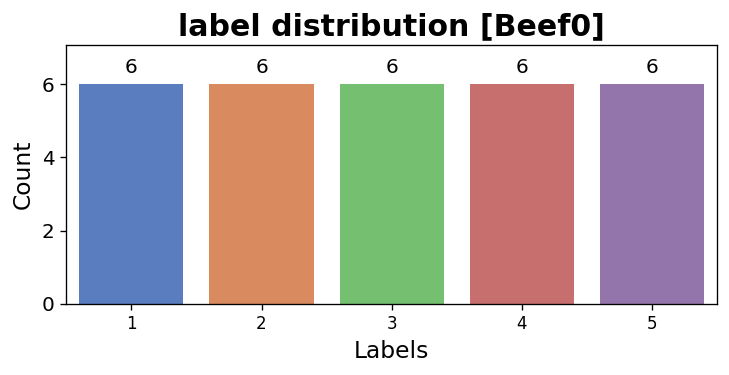

In [164]:
x_t, y_t = dataset_overview(train_test_dct=ds_Beef["y_train_small"] , dataset_name="Beef0")

In [165]:
MR_H_cl = _set_bakeoff_classifier("MR-Hydra", random_state=0, n_jobs=1)
cl_dict = {"MR-Hydra":MR_H_cl}


res_Beef = apply_TSC_algos(train_test_dct=ds_Beef, classifiers=cl_dict)
res_Beef["MR-Hydra"]["accuracy"]

Classifier: MultiRocketHydraClassifier
---------------------------- Train time=0.87s, Eval Time=1.52s

Algorithm                         Accuracy
MR-Hydra                          0.7667


0.7666666666666667

from sklearn.metrics import log_loss

def apply_ml_metrics(res):
    """Apply different metrics to evaluate the overall algorithm performance
       accuracy || balanced_acc? || NegativeLogLikelihood || AUROC || F1_SC
       Receive: DataFrame with y_pred, y_test, y_pred_prob
       Return: DataFrame with columns for each performance Metric"""
    


label_names, label_counts = np.unique(ds_Beef["y_train"], return_counts=True)
label_names.shape[0]
LE_trace_matrix = np.zeros((label_names.shape[0],label_names.shape[0]))
LE_trace_matrix[2,4]
index = np.where(label_names == "3")
index
    

In [162]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from basic_func import dataset_provider,dataset_overview, apply_TSC_algos


def check_for_results(filename_list):
    exist_all = []
    for file_ in filename_list:
        if os.path.exists(file_):
            print(f"File exists: {file_}")
            exist_all.append(True)
        else:
            print(f"File NOT found: {file_}")
            exist_all.append(False)
    if all(exist_all):
        return True
    else:
        print("results are not present with the current experiment parameters")
        return False #If any file with DesignOfExperiment Parameters is not already present
    #read csv in data path
    #Check if currenct_classifer/current_dataset directory exists in current_directory
    #Check if DesignOfExperiment parameter are already present
    # ---> therefore loop through the result files and check the names
    # ---> Justify equality for: RandomS;Start;Stop;Step
 
def apply_label_erros(train_test_df, cl_dict, ds_="ds_0", start=0, stop=10, step=1, stop_percentage=0.25, float_prec=4, exp_folder=None):
    """train_test_df should be a pd.DataFrame with the columns X_train, X_test, y_train, y_test
       and their reduced identity (X_train_small). cl_dict should be a dict out of classifier names
       and their respective instances.
       RETURNS: history_df
                res_
                LE_trace_matrix
       STORES: result files in data_path
                1.line: algorithm data,parameters,train&prediction time                         Konfigurationsfile (yaml)
                2.line: data parameters,current_dataset, current split, random_seed, etc...?                       (yaml)
                3.line: performance metrics acc, bal_acc, NLL, AUROC, F1Sc                      Aufbereitung (visualize(csv))
                4.line: y, y_pred, y_pred_proba, ...                                            Ergebnisse (csv)   
        DATA_PATH: os.path.join(directory_current/cl_/ds_/(cl_+ds_+randomS_+start_+stop_+step_ "_"+ filename_)))           
       """
    cl_ = next(iter(cl_dict))
    dataset_name = ds_
    directory_current = "simulation_results/"
    randomS=0
    filename_ = str(randomS)+ "_" + str(start)+ "_" + str(stop)+ "_" + str(step) +".csv"
    filename_res = ds_ + "_res_" + filename_
    filename_pred = ds_ + "_pred_" + filename_
    filename_trace = ds_ + "_trace_" + filename_
    if exp_folder is not None:
        directory_current = exp_folder
    EXP_PATH = os.path.join(directory_current,cl_, dataset_name)
    RES_PATH = os.path.join(EXP_PATH, filename_res)
    PRED_PATH = os.path.join(EXP_PATH, filename_pred)
    TRACE_PATH = os.path.join(EXP_PATH, filename_trace)
    os.makedirs(EXP_PATH, exist_ok=True)


    #TODO Add LE-Tracing (Which class flips to which class how often, class^2 relations)
    if not check_for_results(filename_list=[RES_PATH, PRED_PATH, TRACE_PATH]):
        cl_names = list(cl_dict.keys())
        X_train, y_train = train_test_df["X_train_small"], train_test_df["y_train_small"]
        X_test, y_test = train_test_df["X_test_small"], train_test_df["y_test_small"]
        error_start = start
        error_increasement = step
        error_perc_incr = np.round(1/y_train.shape[0],float_prec)
        error_stop = stop
        error_stop_perc = stop_percentage
        add_row = True
        black_list= []
        history_df = pd.DataFrame(columns=["step", "LE_instances", "LE_relative", "accuracy"])
        history_df = history_df.astype({"step": "int64","LE_instances": "int64","LE_relative": "float64", "accuracy": "float64"})
        results_df = pd.DataFrame(columns=["iteration","pred_dict"])
        error_relative = 0
        #n_classes (in training data) 
        label_names, label_counts = np.unique(y_train, return_counts=True)
        LE_trace_matrix = np.zeros((label_names.shape[0],label_names.shape[0]))
        
        #for every step between start and stop, intrude a label flip and fit the cl_
        for i_, step_ in enumerate(range(error_start, error_stop, error_increasement)):
            ##############print("current iteration: {}   current LE_step: {} error_relative: {}".format(i_, step_, error_relative))
            if step_ >= 1 and add_row == True:
                for e_i_ in range(1, step + 1 , 1):    
                    if error_relative >= error_stop_perc: ###---break criteria error_relative
                        print(str(error_relative) +"error threshold exceeds the current limit of {0} stop at iteration {1} ".format(error_stop_perc, step_))
                        add_row=False
                        break
                    else:
                        #random_label_choice1 & random_label_choice2 AND Ensure that: rlc2 =/= rlc1
                        #implementation_question: pick randomly accross the whole indexes OR fairly between label_names ?
                        #  
                        rlc1, rlc2 = np.random.choice(label_names, size=2, replace=False)
                        
                        #list all indexes where rcl1 is present
                        idx_l1 = np.where(y_train==rlc1)[0]
                        ##TODO Verify that there are potential instances present from the current class choice which are not in the blacklist
                        ## IF SO: change the class_pick 

                        #convert_label(rc_idx_l1--->random_label2) if rc_idx_l1 is not used AND append rc_idx_l1 to the black_list
                        rc_idx_l1 = np.random.choice(idx_l1)
                        while rc_idx_l1 in black_list:
                            print("PICKED the same instance again. CHANGED PICK SUCCESFULLY")
                            rc_idx_l1 = np.random.choice(idx_l1)
                        y_train[rc_idx_l1] = rlc2
                        black_list.append(rc_idx_l1)
                        LE_trace_matrix[np.where(label_names == rlc1)[0][0], np.where(label_names== rlc2)[0][0]] +=1
                        error_relative += error_perc_incr
                        error_relative = round(error_relative, float_prec)
                        label_names, label_counts = np.unique(y_train, return_counts=True)
                        print(f"changed label {rlc1} to {rlc2} at index {rc_idx_l1} of the data") 
                print("current class balance distribution: {}".format(dict(zip(label_names, label_counts))))

            elif step < 1 and add_row == True:
                pass


            #fit classifier and make prediction
            res_ = apply_TSC_algos(train_test_dct=train_test_df, classifiers=cl_dict)
            print("current iteration: {}   current LE_step: {} error_relative: {}".format(i_, step_, error_relative))
            if add_row:
                history_df.loc[i_] = [int(i_), int(step_), error_relative, np.round(res_[cl_names[0]]["accuracy"],float_prec)]
                results_df.loc[i_] = [int(i_), res_]
            #res should be stored in /David_MA/dca/label_er/<current_cl>/<current_ds>/results.csv # maybe add conf_matrices. delta?
        history_df = history_df.astype({"step": "int64","LE_instances": "int64","LE_relative": "float64", "accuracy": "float64"})
        history_df.to_csv(RES_PATH, index=False)
        results_df.to_csv(PRED_PATH, index=False)
        np.savetxt(TRACE_PATH, LE_trace_matrix, delimiter=",", fmt="%d") 


    else: #if results are already present
        #(load_present_results())
        LE_trace_matrix = np.loadtxt(TRACE_PATH, delimiter=",", dtype=int)
        LE_trace_matrix = LE_trace_matrix.astype(int)
        history_df = pd.read_csv(RES_PATH)
        results_df = pd.read_csv(PRED_PATH)
        res_ = results_df


    return history_df, res_, LE_trace_matrix
    





def visualize_acc_decr(df_acc_inst_rel, w_=6, h_=4, dpi_=150, first="instances", second="relative",
                      cl_="cl_0", ds_="ds_0", filename_="acc_decr",save_fig=False, exp_folder=None):
    """
    VISUALIZE accuracy decrease of one SINGLE dataset/algorithm/DCA -combination.
    RECEIVE: df_acc_inst_rel: DataFrame with the column structure accuracy;LE_instances;LE_relative
             w_, h_, dpi: weight, height and dpi of the figure
             first: first axis type of the visualization. Options: [instances], [relative]
             second: second axis type of the visualization
    RETURNS: Nothing
    STORES: IF save_fig == True: stores figure in exp_path (directory_current/cl_/ds_+filename)
    """
    acc_decr=df_acc_inst_rel["accuracy"]
    LE_instances=df_acc_inst_rel["LE_instances"]
    LE_relative=df_acc_inst_rel["LE_relative"]
    colors = ['tab:blue', 'tab:orange']
    directory_current = "simulation_results/"
    if exp_folder is not None:
        directory_current = exp_folder
    EXP_PATH = os.path.join(directory_current,cl_, (ds_+ "_"+ filename_))

    fig, ax1 = plt.subplots(figsize=(w_, h_), dpi=dpi_)
    fig.suptitle('Impact of Label Errors on Model Accuracy', fontsize=12, fontweight='bold')

    # Plot the number of instances (left y-axis)
    if first == "relative" :
        x_ = LE_relative
        x_label = "Label Errors (Relative)"

    else:
        x_ = LE_instances
        x_label = "Label Errors (Instances)"


    #Initialize first plot
    ax1.set_ylabel('Accuracy Decrease (%)' )
    ax1.set_xlabel(x_label)
    ax1.set_xlim(x_.min(), x_.max()+0.05*x_.max())
    print(ax1.get_xlim())
    ax1.plot(x_ ,acc_decr, color=colors[1], label=cl_)
    ax1.tick_params(axis='y') #labelcolor=colors[0])
    ax1.grid(visible=True, linestyle='--', alpha=0.6, linewidth=0.5)

    def inst2rel(x):
        return df_acc_inst_rel.loc[(df_acc_inst_rel["LE_instances"]==x),"LE_relative"].iloc[0]
    def rel2inst(x):
        return df_acc_inst_rel.loc[(df_acc_inst_rel["LE_relative"]==x),"LE_instances"].iloc[0]

    ###CHECK for second axis
    if not second == None:
        print("CURRENTLY IN DEV MODE")
        if second == "relative":
            x2_ = LE_relative
            x_label = "Label Errors (Relative)"

        elif second =="instances":
            x2_ = LE_instances
            x_label = "Label Errors (Instances)"

        #ax2 = ax1.twiny()
        ax2 = ax1.secondary_xaxis('top', functions=(inst2rel, rel2inst))
        #ax2.plot(x2_, acc_decr, color=colors[0], label=cl_)
        #ax2.tick_params(axis="x")
        ax2.set_xlabel(x_label)

       

    ### Independent of a second axis should be present: 
    # Finalize Figure aesthetics and saveplot
    ax1.legend(loc='upper right')
    fig.tight_layout()
    if save_fig==True:
        os.makedirs(os.path.join(directory_current,cl_), exist_ok=True)
        fig.savefig(fname=(EXP_PATH))


    plt.show()

In [166]:
df_beef, res_beef, trace_m_beef = apply_label_erros(train_test_df=ds_Beef, step=1, ds_="Beef", cl_dict=cl_dict, stop_percentage=0.30)

File exists: simulation_results/MR-Hydra/Beef/Beef_res_0_0_10_1.csv
File exists: simulation_results/MR-Hydra/Beef/Beef_pred_0_0_10_1.csv
File exists: simulation_results/MR-Hydra/Beef/Beef_trace_0_0_10_1.csv


In [167]:
df_beef

,step,LE_instances,LE_relative,accuracy
0,0,0,0.0000,0.7667
1,1,1,0.0333,0.7667
2,2,2,0.0666,0.7667
3,3,3,0.0999,0.7667
4,4,4,0.1332,0.7667
5,5,5,0.1665,0.7333
6,6,6,0.1998,0.6667
7,7,7,0.2331,0.6667
8,8,8,0.2664,0.6667
9,9,9,0.2997,0.6000


In [168]:
trace_m_beef

array([[0, 0, 0, 1, 2],
       [0, 0, 0, 1, 0],
       [1, 1, 0, 0, 0],
       [0, 0, 2, 0, 0],
       [0, 0, 0, 1, 0]])

In [ ]:
res_Beef["MR-H"]

from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

cm = metrics.confusion_matrix(ds_Beef["y_test_small"], res_Beef["MR-H"]["y_pred"])

fig = plt.figure(figsize=(6,4), dpi=150)
sns.heatmap(cm, annot=True, linewidths=.5, square = True, cmap = 'PRGn') #fmt=".0f"
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title("Confusion_Matrix_Beef", size = 15)
fig.tight_layout()

X_train             : (8926, 1, 96)
y_train             : (8926,)
X_test              : (7711, 1, 96)
y_test              : (7711,)
X_train_small       : (892, 1, 96)
y_train_small       : (892,)
X_test_small        : (771, 1, 96)
y_test_small        : (771,)
['1', '2', '3', '4', '5', '6', '7']


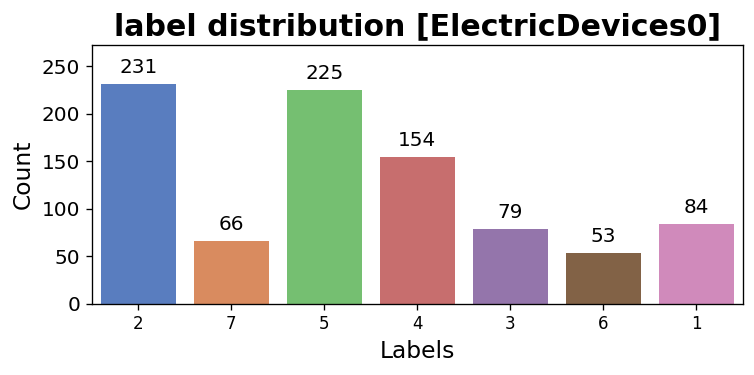

In [20]:
ds_ED, meta_ED = dataset_provider(name="ElectricDevices", reduction_factor=10, test_set_ratio="default_benchmark", random_state=0)
print(meta_ED["class_values"])
x_t, y_t = dataset_overview(train_test_dct=ds_ED["y_train_small"] , dataset_name="ElectricDevices0")


In [ ]:
df_ED, res_ED, trace_m_ED = apply_label_erros(train_test_df=ds_ED, cl_dict=cl_dict, stop=250, step=5)

Classifier: MultiRocketHydraClassifier
---------------------------- Train time=7.12s, Eval Time=8.31s

Algorithm                         Accuracy
MR-H                              0.6874
current iteration: 0   current LE_step: 0 error_relative: 0
changed label 3 to 4 at index 704 of the data
changed label 4 to 6 at index 742 of the data
changed label 1 to 5 at index 163 of the data
changed label 1 to 2 at index 768 of the data
changed label 1 to 5 at index 187 of the data
current class balance distribution: {'1': 81, '2': 232, '3': 78, '4': 154, '5': 227, '6': 54, '7': 66}
Classifier: MultiRocketHydraClassifier
---------------------------- Train time=7.01s, Eval Time=8.29s

Algorithm                         Accuracy
MR-H                              0.6900
current iteration: 1   current LE_step: 5 error_relative: 0.0055
changed label 7 to 6 at index 298 of the data
changed label 3 to 7 at index 238 of the data
changed label 6 to 1 at index 87 of the data
changed label 6 to 4 at index 4

In [22]:
df_ED

,step,LE_instances,LE_relative,accuracy
0,0,0,0.0000,0.6874
1,1,5,0.0055,0.6900
2,2,10,0.0110,0.6861
3,3,15,0.0165,0.6835
4,4,20,0.0220,0.6822
5,5,25,0.0275,0.6887
6,6,30,0.0330,0.6900
7,7,35,0.0385,0.6861
8,8,40,0.0440,0.6719
9,9,45,0.0495,0.6706


In [88]:
# Try it for another algorithm
ds_ED, meta_ED = dataset_provider(name="ElectricDevices", reduction_factor=10, test_set_ratio="default_benchmark", random_state=0)
Weasel_D = _set_bakeoff_classifier("Weasel-D", random_state=0, n_jobs=1)
cl_dict2 = {"Weasel-D": Weasel_D}
df_ED_W2, res_ED_W2, trace_m_ED_W2 = apply_label_erros(train_test_df=ds_ED, cl_dict=cl_dict2, stop=300, stop_percentage=0.6,  step=5)

X_train             : (8926, 1, 96)
y_train             : (8926,)
X_test              : (7711, 1, 96)
y_test              : (7711,)
X_train_small       : (892, 1, 96)
y_train_small       : (892,)
X_test_small        : (771, 1, 96)
y_test_small        : (771,)
Classifier: WEASEL_V2
---------------------------- Train time=6.59s, Eval Time=4.66s

Algorithm                         Accuracy
Weasel-D                          0.7237
current iteration: 0   current LE_step: 0 error_relative: 0
changed label 3 to 4 at index 704 of the data
changed label 4 to 6 at index 742 of the data
changed label 1 to 5 at index 163 of the data
changed label 1 to 2 at index 768 of the data
changed label 1 to 5 at index 187 of the data
current class balance distribution: {'1': 81, '2': 232, '3': 78, '4': 154, '5': 227, '6': 54, '7': 66}
Classifier: WEASEL_V2
---------------------------- Train time=6.28s, Eval Time=4.58s

Algorithm                         Accuracy
Weasel-D                          0.7160
current

In [ ]:
df_ED_W2

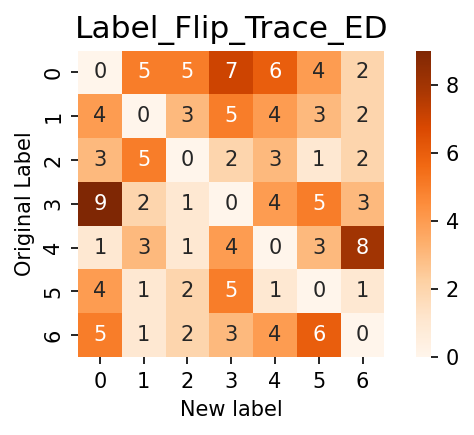

In [25]:
trace_m_ED

from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize=(4.5,3), dpi=150)
sns.heatmap(trace_m_ED_W2, annot=True, linewidths=0, square = True, cmap = 'Oranges') #fmt=".0f"
plt.ylabel('Original Label')
plt.xlabel('New label')
plt.title("Label_Flip_Trace_ED", size = 15)
fig.tight_layout()

In [90]:
trace_m_ED_W2

array([[ 0.,  9.,  8., 12.,  8.,  7.,  5.],
       [ 6.,  0.,  7., 12.,  6.,  5.,  7.],
       [ 6.,  8.,  0.,  6.,  5.,  8., 10.],
       [14.,  3.,  3.,  0.,  6.,  8.,  6.],
       [ 6.,  5.,  4.,  9.,  0.,  8., 14.],
       [10.,  6.,  3.,  8.,  2.,  0.,  4.],
       [ 9.,  6.,  5.,  8.,  7.,  6.,  0.]])

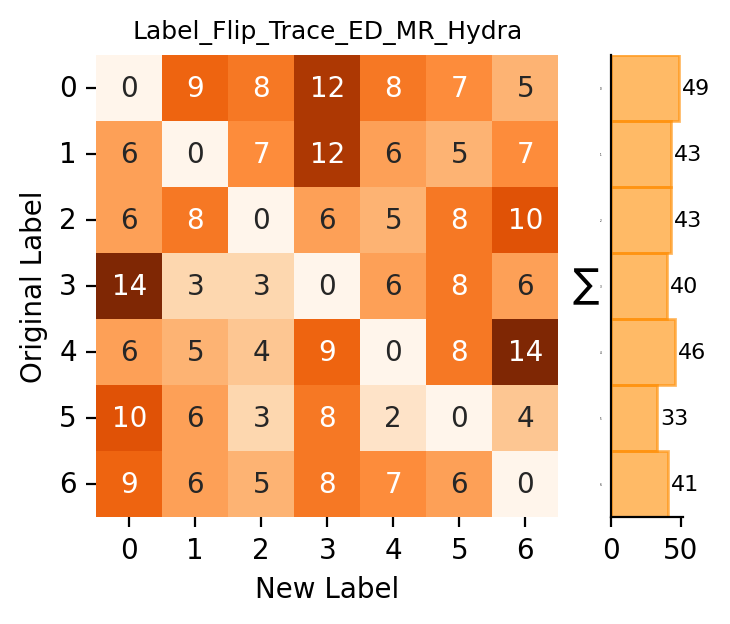

In [100]:
# Compute row sums
def trace_M(trace_M, cl_="cl_0", ds_="ds_0",dpi=200, filename_="trace_M", save_fig=False, exp_folder=None):
    """
    VISUALIZE trace Matrix of one SINGLE dataset/algorithm/DCA -combination.
    RECEIVE: trace_Matrix: DataFrame with the column structure: Original label, New label
    RETURNS: Nothing
    STORES: IF save_fig == True: stores figure in exp_path (directory_current/cl_/ds_/filename_+"_"+paramStr)
            paramStr = randomS_+start_+stop_+step_
    """

        
    colors = ['tab:blue', 'tab:orange'] #TODO
    directory_current = "simulation_results/"
    if exp_folder is not None:
        directory_current = exp_folder
    EXP_PATH = os.path.join(directory_current,cl_, (ds_+ "_"+ filename_))


    row_sums = trace_M.sum(axis=1)

    # Create figure with GridSpec
    fig = plt.figure(figsize=(5.5, 3), dpi=200)
    gs = gridspec.GridSpec(1, 2, width_ratios=[14,1], wspace=-0.4)  # Adjust width_ratios for heatmap and side plot

    # Create heatmap
    ax0 = plt.subplot(gs[0])
    sns.heatmap(trace_M, annot=True, linewidths=0, square=True,cbar=False, cmap='Oranges', ax=ax0)
    ax0.set_ylabel('Original Label')
    ax0.set_xlabel('New Label')
    ax0.set_title("Label_Flip_Trace_"+ds_+ "_"+ cl_, size=9)

    # Create side bar aggregation plot of manipulated original labels 
    ax1 = plt.subplot(gs[1], sharey=ax0)  # Share y-axis with heatmap
    bar_container = ax1.barh(np.arange(len(row_sums)), row_sums, height=1, color='darkorange', align="edge", alpha=0.6, edgecolor="darkorange")  # Horizontal bar chart
    for bar, value in zip(bar_container, row_sums):
        ax1.text(bar.get_width() + 2, bar.get_y() + bar.get_height()/2, f'{value:.0f}', 
                va='center', ha='left', fontsize=8)
    #ax1.set_xticks([])  # Hide x-axis ticks
    #ax1.set_yticks([])  # Hide y-axis labels for clarity
    ax1.spines['top'].set_visible(False)
    ax1.spines['bottom'].set_visible(True)
    ax1.spines['right'].set_visible(False)
    ax0.set_yticklabels(ax0.get_yticklabels(), rotation=0)

    ax1.tick_params(axis="y", which="both", length=0, labelsize=0, color="white", grid_color="white")
    ax1.set_ylabel(r'$\sum$', rotation=0, fontsize=10, labelpad=5, va='center')
    fig.tight_layout()
    plt.show()

trace_M(trace_M=trace_m_ED_W2, cl_="MR_Hydra", ds_="ED",dpi=200, filename_="trace_M", save_fig=False, exp_folder=None)


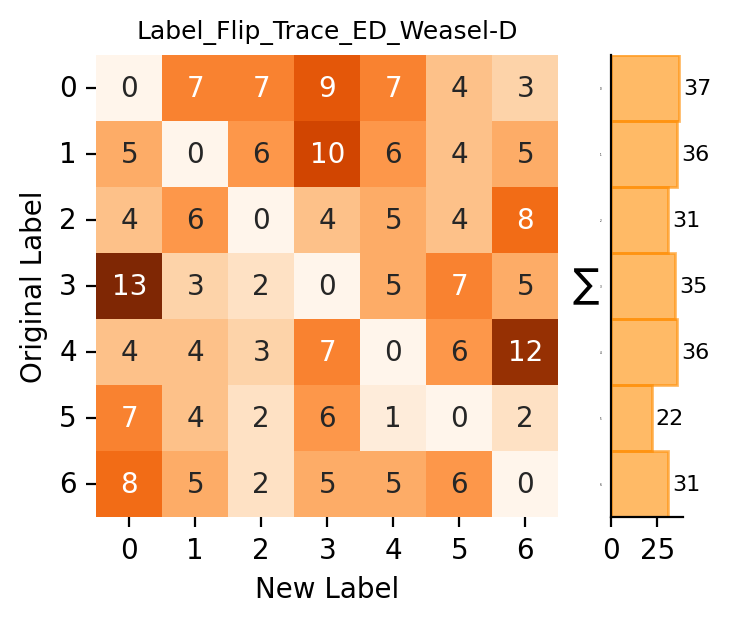

In [95]:
trace_M(trace_M=trace_m_ED, cl_="Weasel-D", ds_="ED",dpi=200, filename_="trace_M", save_fig=False, exp_folder=None)

In [ ]:
# Try it for another dataset.
ds_Chinatown, meta_Chinatown = dataset_provider(name="Chinatown", reduction_factor=1, test_set_ratio="default_benchmark", random_state=0)
print(meta_Chinatown["class_values"])

In [ ]:
# Simulate data
accuracy_decrease = df_ED["accuracy"]  # Accuracy decrease in %
num_instances = df_ED["LE_instances"]    # Number of instances with label errors
relative_errors = df_ED["LE_relative"]  # Relative errors as a percentage of total dataset

# Create the plot
fig, ax1 = plt.subplots(figsize=(6, 4), dpi=130)

# Plot the number of instances (left y-axis)
color = 'tab:blue'
ax1.set_ylabel('Accuracy Decrease (%)' ,color=color)
ax1.set_xlabel('Label Errors (Instances)')
ax1.plot(num_instances ,accuracy_decrease, color=color, label='Number of Instances')
ax1.tick_params(axis='y', labelcolor=color)

# Add gridlines
ax1.grid(visible=True, linestyle='--', alpha=0.6, linewidth=0.5)
#ax1.tick_params(axis='x', labelcolor="blue")
#ax1.tick_params(axis='y', labelcolor="blue")

# Create a second y-axis for relative errors
color2 = 'tab:orange'
ax2 = ax1.twiny()
#ax2.plot(relative_errors, accuracy_decrease, color=color2)
ax2.set_xlim(ax1.get_xlim())  # Match the limits of the primary X-axis
selected_ticks = num_instances[::5]  # Take every 4th tick
selected_relative_errors = relative_errors[::5]  # Match relative errors for the same ticks
ax2.set_xticks(selected_ticks)
ax2.set_xticklabels([f"{x:.1%}" for x in selected_relative_errors])  # Convert to percentage
ax2.set_xlabel("Label Errors (Relative)", color=color2)
ax2.tick_params(axis='x', labelcolor=color2)

# Add title and legend
fig.suptitle('Impact of Label Errors on Model Accuracy', fontsize=16, fontweight='bold')
ax1.legend(loc='upper right')
#ax2.legend(loc='upper right')

# Show the plot
plt.tight_layout()
plt.show()


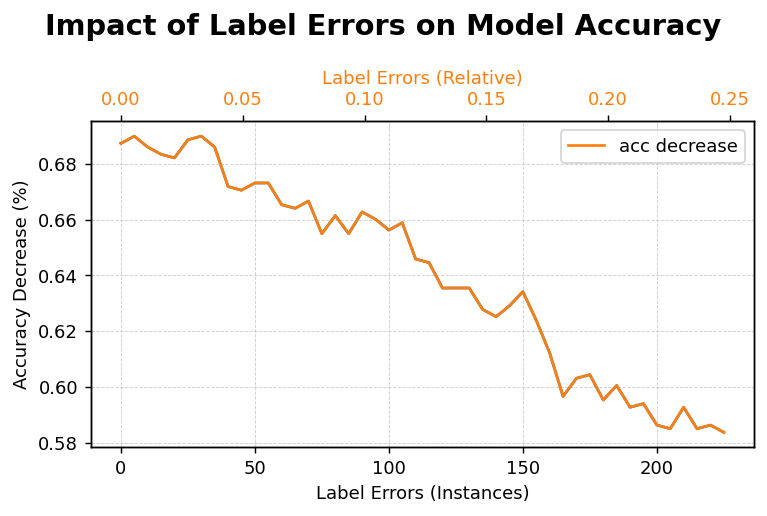

In [40]:
accuracy_decrease = df_ED["accuracy"]  # Accuracy decrease in %
num_instances = df_ED["LE_instances"]    # Number of instances with label errors
relative_errors = df_ED["LE_relative"]  # Relative errors as a percentage of total dataset

# Create the plot
fig, ax1 = plt.subplots(figsize=(6, 4), dpi=130)

# Plot the number of instances (left y-axis)
color = 'tab:blue'
ax1.set_ylabel('Accuracy Decrease (%)' )
ax1.set_xlabel('Label Errors (Instances)')
ax1.plot(num_instances ,accuracy_decrease, color=color, label='Number of Instances')

# Add gridlines
ax1.grid(visible=True, linestyle='--', alpha=0.6, linewidth=0.5)
#ax1.tick_params(axis='x', labelcolor="blue")
#ax1.tick_params(axis='y', labelcolor="blue")

# Create a second y-axis for relative errors
color2 = 'tab:orange'
ax2 = ax1.twiny()
ax2.plot(relative_errors, accuracy_decrease, color=color2, label='acc decrease')
ax2.tick_params(axis="x", labelcolor=color2)
#ax2.set_xlim(ax1.get_xlim())  # Match the limits of the primary X-axis
ax2.set_xlabel("Label Errors (Relative)",color=color2)

fig.suptitle('Impact of Label Errors on Model Accuracy', fontsize=16, fontweight='bold')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [57]:
df_ED.loc[(df_ED["LE_instances"]==20),"LE_relative"]

4    0.022
Name: LE_relative, dtype: float64

In [83]:
def visualize_acc_decr(df_acc_inst_rel, w_=6, h_=4, dpi_=150, first="instances", second="relative",
                      cl_="cl_0", ds_="ds_0", filename_="acc_decr",save_fig=False, exp_folder=None):
    """
    VISUALIZE accuracy decrease of one SINGLE dataset/algorithm/DCA -combination.
    RECEIVE: df_acc_inst_rel: DataFrame with the column structure accuracy;LE_instances;LE_relative
             w_, h_, dpi: weight, height and dpi of the figure
             first: first axis type of the visualization. Options: [instances], [relative]
             second: second axis type of the visualization
    RETURNS: Nothing
    STORES: IF save_fig == True: stores figure in exp_path (directory_current/cl_/ds_+filename)
    """
    acc_decr=df_acc_inst_rel["accuracy"]
    LE_instances=df_acc_inst_rel["LE_instances"]
    LE_relative=df_acc_inst_rel["LE_relative"]
    colors = ['tab:blue', 'tab:orange']
    directory_current = "simulation_results/"
    if exp_folder is not None:
        directory_current = exp_folder
    EXP_PATH = os.path.join(directory_current,cl_, (ds_+ "_"+ filename_))

    fig, ax1 = plt.subplots(figsize=(w_, h_), dpi=dpi_)
    fig.suptitle('Impact of Label Errors on Model Accuracy', fontsize=12, fontweight='bold')

    # Plot the number of instances (left y-axis)
    if first == "relative" :
        x_ = LE_relative
        x_label = "Label Errors (Relative)"

    else:
        x_ = LE_instances
        x_label = "Label Errors (Instances)"


    #Initialize first plot
    ax1.set_ylabel('Accuracy Decrease (%)' )
    ax1.set_xlabel(x_label)
    ax1.set_xlim(x_.min(), x_.max()+0.05*x_.max())
    print(ax1.get_xlim())
    ax1.plot(x_ ,acc_decr, color=colors[1], label=cl_)
    ax1.tick_params(axis='y') #labelcolor=colors[0])
    ax1.grid(visible=True, linestyle='--', alpha=0.6, linewidth=0.5)

    def inst2rel(x):
        return df_acc_inst_rel.loc[(df_acc_inst_rel["LE_instances"]==x),"LE_relative"].iloc[0]
    def rel2inst(x):
        return df_acc_inst_rel.loc[(df_acc_inst_rel["LE_relative"]==x),"LE_instances"].iloc[0]

    ###CHECK for second axis
    if not second == None:
        print("CURRENTLY IN DEV MODE")
        if second == "relative":
            x2_ = LE_relative
            x_label = "Label Errors (Relative)"

        elif second =="instances":
            x2_ = LE_instances
            x_label = "Label Errors (Instances)"

        #ax2 = ax1.twiny()
        ax2 = ax1.secondary_xaxis('top', functions=(inst2rel, rel2inst))
        #ax2.plot(x2_, acc_decr, color=colors[0], label=cl_)
        #ax2.tick_params(axis="x")
        ax2.set_xlabel(x_label)

       

    ### Independent of a second axis should be present: 
    # Finalize Figure aesthetics and saveplot
    ax1.legend(loc='upper right')
    fig.tight_layout()
    if save_fig==True:
        os.makedirs(os.path.join(directory_current,cl_), exist_ok=True)
        fig.savefig(fname=(EXP_PATH))


    plt.show()

(0.0, 0.259875)


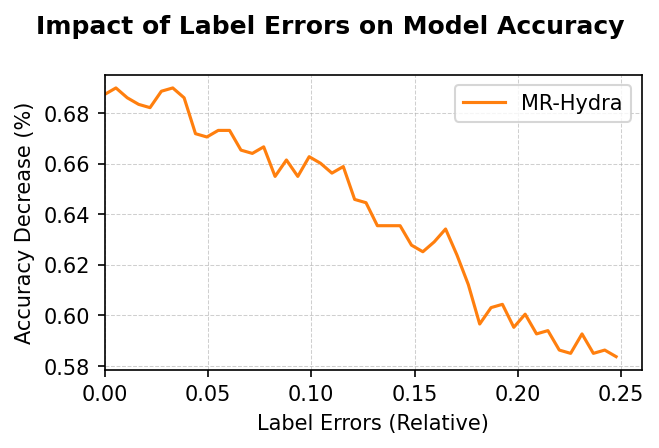

In [97]:
visualize_acc_decr(df_acc_inst_rel=df_ED, dpi_=150, first="relative", second=None, w_=4.5, h_=3,
                   cl_="MR-Hydra", ds_="ElectricDevices", save_fig=True)

(0.0, 0.259875)


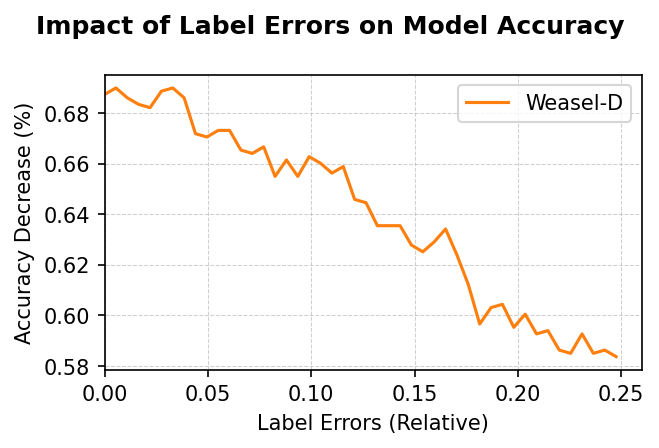

In [96]:
visualize_acc_decr(df_acc_inst_rel=df_ED, dpi_=150, first="relative", second=None, w_=4.5, h_=3,
                   cl_="Weasel-D", ds_="ElectricDevices", save_fig=True)

In [68]:
df_acc_inst_rel = df_ED
x = 20

In [76]:
df_acc_inst_rel.loc[(df_acc_inst_rel["LE_instances"]==x),"LE_relative"].iloc[0]

0.022

In [98]:
from aeon.datasets.tsc_datasets import univariate
univariate

{'ACSF1',
 'Adiac',
 'AllGestureWiimoteX',
 'AllGestureWiimoteY',
 'AllGestureWiimoteZ',
 'ArrowHead',
 'BME',
 'Beef',
 'BeetleFly',
 'BirdChicken',
 'CBF',
 'Car',
 'Chinatown',
 'ChlorineConcentration',
 'CinCECGTorso',
 'Coffee',
 'Computers',
 'CricketX',
 'CricketY',
 'CricketZ',
 'Crop',
 'DiatomSizeReduction',
 'DistalPhalanxOutlineAgeGroup',
 'DistalPhalanxOutlineCorrect',
 'DistalPhalanxTW',
 'DodgerLoopDay',
 'DodgerLoopGame',
 'DodgerLoopWeekend',
 'ECG200',
 'ECG5000',
 'ECGFiveDays',
 'EOGHorizontalSignal',
 'EOGVerticalSignal',
 'Earthquakes',
 'ElectricDevices',
 'EthanolLevel',
 'FaceAll',
 'FaceFour',
 'FacesUCR',
 'FiftyWords',
 'Fish',
 'FordA',
 'FordB',
 'FreezerRegularTrain',
 'FreezerSmallTrain',
 'Fungi',
 'GestureMidAirD1',
 'GestureMidAirD2',
 'GestureMidAirD3',
 'GesturePebbleZ1',
 'GesturePebbleZ2',
 'GunPoint',
 'GunPointAgeSpan',
 'GunPointMaleVersusFemale',
 'GunPointOldVersusYoung',
 'Ham',
 'HandOutlines',
 'Haptics',
 'Herring',
 'HouseTwenty',
 'Inli